In [28]:
import os
import glob

import numpy as np
import functools
import xarray as xr
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client

In [29]:
# Setup PBSCluster
cluster = PBSCluster(
    cores=1,                                                   # The number of cores you want
    memory='25GB',                                             # Amount of memory
    processes=1,                                               # How many processes
    queue='casper',                                            # The type of queue to utilize
    local_directory='/glade/work/afoster',                     # Use your local directory
    resource_spec='select=1:ncpus=1:mem=25GB',                 # Specify resources
    log_directory='/glade/derecho/scratch/afoster/dask_logs',  # log directory
    account='P08010000',                                       # Input your project ID here
    walltime='02:00:00',                                       # Amount of wall time
    interface='ext')                                           # Interface to use

cluster.scale(10)
dask.config.set({
    'distributed.dashboard.link': 'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
})
client = Client(cluster)
client

/glade/work/afoster/conda-envs/fates_calibration/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34711 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/afoster/proxy/34711/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/afoster/proxy/34711/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.96:42295,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/afoster/proxy/34711/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [30]:
#client.shutdown()

In [31]:
def preprocess(ds, varset):
    return ds[varset]

def get_files(archive_dir, case_name):
    return sorted(glob.glob(os.path.join(archive_dir, case_name, 'lnd', 'hist/') + "*clm2.h0*.nc"))

def annual_mean(da, cf):

    days_per_month = da['time.daysinmonth']
    ann_mean = cf*(days_per_month*da).groupby('time.year').sum()
    ann_mean.name = da.name

    return ann_mean

In [32]:
def get_ds(files, vars, fates=True):
    ds = xr.open_mfdataset(files, combine='nested', concat_dim='time',
                       preprocess=functools.partial(preprocess,
                                                    varset=vars),
                       parallel=True, autoclose=True)

    ds['time'] = xr.cftime_range(str(2005), periods=len(ds.time), freq='MS')

    if fates:
        ds['GPP'] = ds['FATES_GPP']*ds['FATES_FRACTION']  # kg m-2 s-1
        ds['GPP'].attrs['units'] = 'kg m-2 s-1'
        ds['GPP'].attrs['long_name'] = ds['FATES_GPP'].attrs['long_name']
    
        ds['LAI'] = ds['FATES_LAI']*ds['FATES_FRACTION']  # kg m-2 s-1
        ds['LAI'].attrs['units'] = 'm2 m-2'
        ds['LAI'].attrs['long_name'] = ds['FATES_LAI'].attrs['long_name']
    else:
        ds['GPP'] = ds['FPSN']*1E-6*12.011/1000.0 # kg m-2 s-1
        ds['GPP'].attrs['units'] = 'kg m-2 s-1'
        ds['GPP'].attrs['long_name'] = ds['FPSN'].attrs['long_name']
    
        ds['LAI'] = ds['TLAI'] # m m-2 
        ds['LAI'].attrs['units'] = ds['TLAI'].attrs['units']
        ds['LAI'].attrs['long_name'] = ds['TLAI'].attrs['long_name']

    sh = ds.FSH
    le = ds.EFLX_LH_TOT
    energy_threshold = 20
    
    sh = sh.where((sh > 0) & (le > 0) & ((le + sh) > energy_threshold))
    le = le.where((sh > 0) & (le > 0) & ((le + sh) > energy_threshold))
    ds['EF'] = le/(le + sh)
    ds['EF'].attrs['units'] = 'unitless'
    ds['EF'].attrs['long_name'] = 'Evaporative fraction'

    ds['ASA'] = ds.FSR/ds.FSDS.where(ds.FSDS > 0)
    ds['ASA'].attrs['units'] = 'unitless'
    ds['ASA'].attrs['long_name'] = 'All sky albedo'
    
    ds['RLNS'] = ds.FLDS - ds.FIRE
    ds['RLNS'].attrs['units'] = 'W m-2'
    ds['RLNS'].attrs['long_name'] = 'surface net longwave radiation'
    
    ds['RN'] = ds.FLDS - ds.FIRE + ds.FSDS - ds.FSR
    ds['RN'].attrs['units'] = 'W m-2'
    ds['RN'].attrs['long_name'] = 'surface net radiation'
    
    ds['Temp'] = ds.TSA - 273.15
    ds['Temp'].attrs['units'] = 'degrees C'
    ds['Temp'].attrs['long_name'] = ds['TSA'].attrs['long_name']

    return ds

In [33]:
def get_annual_ds(ds):
    gpp = annual_mean(ds.GPP, 24*60*60).mean(dim='year')
    lh = annual_mean(ds.EFLX_LH_TOT, 1/365).mean(dim='year')
    sh = annual_mean(ds.FSH, 1/365).mean(dim='year')
    ef = annual_mean(ds.EF, 1/365).mean(dim='year')
    alb = annual_mean(ds.ASA, 1/365).mean(dim='year')
    fsr = annual_mean(ds.FSR, 1/365).mean(dim='year')
    fsa = annual_mean(ds.FSA, 1/365).mean(dim='year')
    fire = annual_mean(ds.FIRE, 1/365).mean(dim='year')
    rlns = annual_mean(ds.RLNS, 1/365).mean(dim='year')
    rn = annual_mean(ds.RN, 1/365).mean(dim='year')
    lai = annual_mean(ds.LAI, 1/365).mean(dim='year')
    temp = annual_mean(ds.Temp, 1/365).mean(dim='year')
    htop = annual_mean(ds.HTOP, 1/365).mean(dim='year')
    tlai = annual_mean(ds.TLAI, 1/365).mean(dim='year')

    ds = xr.merge([gpp, lh, sh, ef, alb, fsr, fsa, fire, rlns, rn, lai, temp, htop, tlai])
    return ds

In [34]:
def get_diff(ds, var):

    var_diff = ds[var].sel(version='pr') - ds[var].sel(version='master')
    return var_diff

In [35]:
def get_rel_diff(ds, var):

    var_old = ds[var].sel(version='master')
    var_diff = ds[var].sel(version='pr') - ds[var].sel(version='master')
    rel_diff = var_diff/var_old
    return rel_diff

In [36]:
fsurdat = os.path.join('/glade/campaign/cesm/cesmdata/inputdata/lnd/',
                       'clm2/surfdata_esmf/ctsm5.3.0/',
                       'surfdata_1.9x2.5_hist_2000_16pfts_c240908.nc')
surdat = xr.open_dataset(fsurdat)

In [65]:
archive_dir = '/glade/derecho/scratch/afoster/archive'

case_fates_master = 'ctsm60SP_fates_master'
case_fates_pr = 'ctsm60SP_fates_pr_test2'
case_bigleaf_master = 'ctsm60SP_bigleaf_master'
case_bigleaf_pr = 'ctsm60SP_bigleaf_pr'

data_vars_fates = ['FATES_GPP', 'FATES_FRACTION', 'QVEGE', 'QVEGT', 'EFLX_LH_TOT', 'FSH', 'QRUNOFF',
             'SOILWATER_10CM', 'FSR', 'FSDS', 'FSA', 'FIRE', 'FLDS', 'RAIN',
             'SNOW', 'H2OSNO', 'SNOWDP', 'TSA', 'landfrac', 'area', 'FATES_LAI',
             'HTOP', 'TLAI']
data_vars_bigleaf = ['FPSN', 'QVEGE', 'QVEGT', 'EFLX_LH_TOT', 'FSH', 'QRUNOFF',
             'SOILWATER_10CM', 'FSR', 'FSDS', 'FSA', 'FIRE', 'FLDS', 'RAIN',
             'SNOW', 'H2OSNO', 'SNOWDP', 'TSA', 'landfrac', 'area', 'TLAI']

In [66]:
files_fates_master = get_files(archive_dir, case_fates_master)
files_bigleaf_master = get_files(archive_dir, case_bigleaf_master)
files_fates_pr = get_files(archive_dir, case_fates_pr)
files_bigleaf_pr = get_files(archive_dir, case_bigleaf_pr)

In [67]:
ds_fates_master = get_ds(files_fates_master, data_vars_fates)
ds_bigleaf_master = get_ds(files_bigleaf_master, data_vars_bigleaf, fates=False)
ds_fates_pr = get_ds(files_fates_pr, data_vars_fates)
ds_bigleaf_pr = get_ds(files_bigleaf_pr, data_vars_bigleaf, fates=False)

In [68]:
all_fates = xr.concat([ds_fates_master, ds_fates_pr], dim='version')
all_fates = all_fates.assign_coords(version=('version', ['master', 'pr']))
all_bigleaf = xr.concat([ds_bigleaf_master, ds_bigleaf_pr], dim='version')
all_bigleaf = all_bigleaf.assign_coords(version=('version', ['master', 'pr']))

In [69]:
htop = annual_mean(all_fates.HTOP, 1/365)
tlai = annual_mean(all_fates.TLAI, 1/365)

In [70]:
all_fates_annual = get_annual_ds(all_fates)

In [71]:
gpp_diff = get_diff(all_fates_annual, 'GPP')
lh_diff = get_diff(all_fates_annual, 'EFLX_LH_TOT')
sh_diff = get_diff(all_fates_annual, 'FSH')
ef_diff = get_diff(all_fates_annual, 'EF')
alb_diff = get_diff(all_fates_annual, 'ASA')
fsr_diff = get_diff(all_fates_annual, 'FSR')
fsa_diff = get_diff(all_fates_annual, 'FSA')
fire_diff = get_diff(all_fates_annual, 'FIRE')
rlns_diff = get_diff(all_fates_annual, 'RLNS')
rn_diff = get_diff(all_fates_annual, 'RN')
lai_diff = get_diff(all_fates_annual, 'TLAI')
temp_diff = get_diff(all_fates_annual, 'Temp')

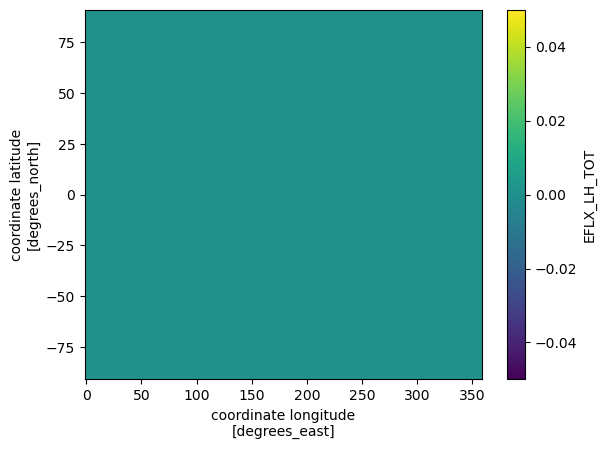

In [75]:
lh_diff.plot()